In [1]:
# API 키를 환경변수로 관리하기 위한 설정 파일
from dotenv import load_dotenv

# API 키 정보 로드
load_dotenv()

True

In [2]:
# LangSmith 추적을 설정합니다. https://smith.langchain.com
# !pip install -qU langchain-teddynote
from langchain_teddynote import logging

# 프로젝트 이름을 입력합니다.
logging.langsmith("CH15-React-Agent")

LangSmith 추적을 시작합니다.
[프로젝트명]
CH15-React-Agent


## React Agent

![](assets/agent.png)

In [3]:
from langchain_openai import ChatOpenAI
from langchain_teddynote.tools.tavily import TavilySearch
from langchain_core.messages import HumanMessage
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import create_react_agent

# 메모리 설정
memory = MemorySaver()

# 모델 설정
model = ChatOpenAI(model_name="gpt-4o-mini")

## 도구 설정

### 웹 검색


In [4]:
from langchain_teddynote.tools.tavily import TavilySearch


web_search = TavilySearch(
    topic="general",  # 뉴스 주제 (general 또는 news)
    max_results=5,  # 최대 검색 결과
    include_answer=False,
    include_raw_content=False,
    include_images=False,
    format_output=False,  # 결과 포맷팅
)

web_search.name = "web_search"
web_search.description = (
    "Use this tool to search on the web for any topic other than news."
)

In [5]:
result = web_search.search("SK AI SUMMIT 2024 관련된 정보를 찾아줘")
print(result)

[{'title': "SKT to Host Large-Scale 'SK AI Summit 2024' at COEX in Seoul Next Month", 'url': 'http://www.koreaittimes.com/news/articleView.html?idxno=135066', 'content': "A major AI summit, featuring numerous international and domestic AI experts and entrepreneurs, will be held in Seoul this November.SK Telecom (SKT) announced on October 7th that they will be hosting the 'SK AI Summit 2024' from November 4th to 5th at COEX in Gangnam, Seoul.The summit will br", 'score': 0.9995876, 'raw_content': None}, {'title': '[SK AI Summit 2024] "AI TOMORROW, AI TOGETHER" SK AI SUMMIT 2024, 글로벌 ...', 'url': 'https://news.sktelecom.com/208288', 'content': '[SK AI Summit 2024] “AI TOMORROW, AI TOGETHER” SK AI SUMMIT 2024, 글로벌 AI 기술의 장 – SK텔레콤 뉴스룸 SK텔레콤 뉴스룸 | [SK AI Summit 2024] “AI TOMORROW, AI TOGETHER” SK AI SUMMIT 2024, 글로벌 AI 기술의 장 [SK AI Summit 2024] “AI TOMORROW, AI TOGETHER” SK AI SUMMIT 2024, 글로벌 AI 기술의 장 SK AI SUMMIT SK 전시 부스에 위치한 AIDC 모습을 한 전시존 SK AI SUMMIT SKT A.X 전시 부스에서 설명을 듣고 있는 참관객 SK 

### 파일 관리


In [6]:
from langchain_community.agent_toolkits import FileManagementToolkit

# 'tmp'라는 이름의 디렉토리를 작업 디렉토리로 설정합니다.
working_directory = "tmp"

# FileManagementToolkit 객체를 생성합니다.
file_management_tools = FileManagementToolkit(
    root_dir=str(working_directory),
).get_tools()

In [7]:
# 파일 관리 도구 출력
file_management_tools

[CopyFileTool(root_dir='tmp'),
 DeleteFileTool(root_dir='tmp'),
 FileSearchTool(root_dir='tmp'),
 MoveFileTool(root_dir='tmp'),
 ReadFileTool(root_dir='tmp'),
 WriteFileTool(root_dir='tmp'),
 ListDirectoryTool(root_dir='tmp')]

## Retriever 도구

In [8]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings
from langchain.document_loaders import PDFPlumberLoader

# PDF 파일 로드. 파일의 경로 입력
loader = PDFPlumberLoader("data/SPRI_AI_Brief_2023년12월호_F.pdf")

# 텍스트 분할기를 사용하여 문서를 분할합니다.
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=100)

# 문서를 로드하고 분할합니다.
split_docs = loader.load_and_split(text_splitter)

# VectorStore를 생성합니다.
vector = FAISS.from_documents(split_docs, OpenAIEmbeddings())

# Retriever를 생성합니다.
pdf_retriever = vector.as_retriever()

In [9]:
from langchain_core.tools.retriever import create_retriever_tool
from langchain_core.prompts import PromptTemplate

# PDF 문서를 기반으로 검색 도구 생성
retriever_tool = create_retriever_tool(
    pdf_retriever,
    "pdf_retriever",
    "Search and return information about SPRI AI Brief PDF file. It contains useful information on recent AI trends. The document is published on Dec 2023.",
    document_prompt=PromptTemplate.from_template(
        "<document><context>{page_content}</context><metadata><source>{source}</source><page>{page}</page></metadata></document>"
    ),
)

도구 목록을 정의합니다.

In [10]:
tools = [web_search, *file_management_tools, retriever_tool]
tools

[TavilySearch(name='web_search', description='Use this tool to search on the web for any topic other than news.', client=<tavily.tavily.TavilyClient object at 0x15832bc90>, max_results=5, include_raw_content=False),
 CopyFileTool(root_dir='tmp'),
 DeleteFileTool(root_dir='tmp'),
 FileSearchTool(root_dir='tmp'),
 MoveFileTool(root_dir='tmp'),
 ReadFileTool(root_dir='tmp'),
 WriteFileTool(root_dir='tmp'),
 ListDirectoryTool(root_dir='tmp'),
 Tool(name='pdf_retriever', description='Search and return information about SPRI AI Brief PDF file. It contains useful information on recent AI trends. The document is published on Dec 2023.', args_schema=<class 'langchain_core.tools.retriever.RetrieverInput'>, func=functools.partial(<function _get_relevant_documents at 0x13fab5da0>, retriever=VectorStoreRetriever(tags=['FAISS', 'OpenAIEmbeddings'], vectorstore=<langchain_community.vectorstores.faiss.FAISS object at 0x13f286f90>, search_kwargs={}), document_prompt=PromptTemplate(input_variables=['pag

## 에이전트 생성

In [11]:
from langgraph.prebuilt import create_react_agent

agent_executor = create_react_agent(model, tools, checkpointer=memory)

에이전트를 시각화 합니다.

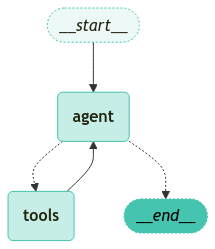

In [12]:
from langchain_teddynote.graphs import visualize_graph

visualize_graph(agent_executor)

## 출력 함수 정의

In [13]:
from langchain_teddynote.messages import stream_graph

In [14]:
# Config 설정
config = {"configurable": {"thread_id": "abc123"}}
inputs = {"messages": [("human", "안녕? 내 이름은 테디야")]}

# 그래프 스트림
stream_graph(agent_executor, inputs, config, node_names=["agent"])


🔄 Node: agent 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
안녕하세요, 테디! 만나서 반가워요. 어떻게 도와드릴까요?

In [17]:
config = {"configurable": {"thread_id": "abc123"}}
inputs = {"messages": [("human", "내 이름이 뭐라고?")]}

# 그래프 스트림
stream_graph(agent_executor, inputs, config, node_names=["agent"])


🔄 Node: agent 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
당신의 이름은 테디입니다. 맞습니까?

In [18]:
config = {"configurable": {"thread_id": "abc123"}}
inputs = {
    "messages": [
        ("human", "AI Brief 보고서에서 Anthropic 투자 관련된 정보를 요약해줘.")
    ]
}
stream_graph(agent_executor, inputs, config, node_names=["agent", "tools"])


🔄 Node: agent 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 

🔄 Node: tools 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
<document><context>n 구글은 수익률이 높은 클라우드 컴퓨팅 시장에서 아마존과 마이크로소프트를 따라잡고자 생성 AI를
통한 기업 고객의 클라우드 지출 확대를 위해 AI 투자를 지속
∙ 구글은 앤스로픽 외에도 AI 동영상 제작 도구를 개발하는 런웨이(Runway)와 오픈소스 소프트웨어
기업 허깅 페이스(Hugging Face)에도 투자
∙ 구글은 챗GPT의 기반 기술과 직접 경쟁할 수 있는 차세대 LLM ‘제미니(Gemini)’를 포함한 자체 AI
시스템 개발에도 수십억 달러를 투자했으며, 2024년 제미니를 출시할 계획
☞ 출처 : The Wall Street Journal, Google Commits $2 Billion in Funding to AI Startup Anthropic, 2023.10.27.
Bloomberg, AI Startup Anthropic to Use Google Chips in Expanded Partnership, 2023.11.09.</context><metadata><source>data/SPRI_AI_Brief_2023년12월호_F.pdf</source><page>13</page></metadata></document>

<document><context>중점 지원할 예정
∙ 포럼에 따르면 AI 레드팀에 대한 자금 지원은 AI 모델의 안전과 보안 기준의 개선과 함께 AI 시스템
위험 대응 방안에 관한 산업계와 정부, 시민사회의 통찰력 확보에 도움이 될 전망으로, 포럼은 향후 몇
달 안에 기금 지원을 위한 제안 요청을 받을 계획
n 프런티어 모델 포럼은 출범 이후 업계 전반에 걸쳐 AI 레드팀 구성에 관한 모범사례 공유를 추진하는
한편, 첨단 AI 모델의 취약점이나 잠재적으로 

In [19]:
config = {"configurable": {"thread_id": "abc123"}}
inputs = {
    "messages": [
        (
            "human",
            "한강 작가의 노벨상 수상 관련된 뉴스를 검색하고 보고서 형식에 맞게 작성해줘",
        )
    ]
}
stream_graph(agent_executor, inputs, config, node_names=["agent", "tools"])


🔄 Node: agent 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 

🔄 Node: tools 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
[{"title": "한강 \"정말 놀랍고 영광…작가들의 노력과 힘이 영감 줬다\"(종합) | 연합뉴스", "url": "https://www.yna.co.kr/view/AKR20241010173051009", "content": "한강 \"정말 놀랍고 영광…작가들의 노력과 힘이 영감 줬다\"(종합) | 연합뉴스 한국인 최초로 노벨문학상을 수상한 소설가 한강(53)은 10일 \"매우 놀랍고 영광스럽다\"는 수상 소감을 밝혔다. 노벨 문학상에 소설가 한강…한국 작가 최초 수상 쾌거(서울=연합뉴스) 스웨덴 한림원은 10일(현지시간) 2024년 노벨 문학상 수상자로 우리나라 소설가 한강 작가를 선정했다고 밝혔다. (서울=연합뉴스) 권수현 임지우 기자 = 한국인 최초로 노벨문학상을 수상한 소설가 한강(53)은 10일 \"매우 놀랍고 영광스럽다\"는 수상 소감을 밝혔다. 한국인으로는 처음으로 문학상을 받게 된 데에는 \"어릴 때부터 책과 함께 자랐고 한국 문학과 함께 성장했다고 할 수 있다\"며 \"한국 문학 독자들과 동료 작가들에게 좋은 소식이 됐으면 좋겠다\"고 답했다. 따라서 내 최근작인 '작별하지 않는다'가 시작이 될 수 있기를 바란다\"며 \"그리고 '소년이 온다'는 이 책 '작별하지 않는다'와 직접적으로 연결이 돼 있다\"고 설명했다. 그리고 '채식주의자'도 있다\"면서 \"하지만 '작별하지 않는다'로 시작해봐도 좋겠다\"고 말했다.", "score": 0.9998416, "raw_content": null}, {"title": "소설가 한강, 한국인 첫 노벨 문학상 수상 영예 - BBC News 코리아", "url": "https://www.bbc.com/korean/articles/c93yewwr666o", "con

In [20]:
instruction = """
당신의 임무는 `보도자료`를 작성하는 것입니다.
----
다음의 내용을 순서대로 처리해 주세요.
1. `한강 작가의 노벨상 수상` 관련된 뉴스를 검색해 주세요.
2. 노벨상 수상 관련 뉴스를 바탕으로 보고서 / 보드자료 작성해 주세요.
3. 단, 중간에 요점 정리를 위한 markdown 테이블 형식 요약을 적극 활용해 주세요.
4. 출력 결과를 파일로 저장해 주세요. (파일 이름은 "agent_press_release.md")
"""

In [21]:
config = {"configurable": {"thread_id": "abc123"}}
inputs = {"messages": [("human", instruction)]}
stream_graph(agent_executor, inputs, config, node_names=["agent", "tools"])


🔄 Node: agent 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 

🔄 Node: tools 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
[{"title": "한강 \"정말 놀랍고 영광…작가들의 노력과 힘이 영감 줬다\"(종합) | 연합뉴스", "url": "https://www.yna.co.kr/view/AKR20241010173051009", "content": "한강 \"정말 놀랍고 영광…작가들의 노력과 힘이 영감 줬다\"(종합) | 연합뉴스 한국인 최초로 노벨문학상을 수상한 소설가 한강(53)은 10일 \"매우 놀랍고 영광스럽다\"는 수상 소감을 밝혔다. 노벨 문학상에 소설가 한강…한국 작가 최초 수상 쾌거(서울=연합뉴스) 스웨덴 한림원은 10일(현지시간) 2024년 노벨 문학상 수상자로 우리나라 소설가 한강 작가를 선정했다고 밝혔다. (서울=연합뉴스) 권수현 임지우 기자 = 한국인 최초로 노벨문학상을 수상한 소설가 한강(53)은 10일 \"매우 놀랍고 영광스럽다\"는 수상 소감을 밝혔다. 한국인으로는 처음으로 문학상을 받게 된 데에는 \"어릴 때부터 책과 함께 자랐고 한국 문학과 함께 성장했다고 할 수 있다\"며 \"한국 문학 독자들과 동료 작가들에게 좋은 소식이 됐으면 좋겠다\"고 답했다. 따라서 내 최근작인 '작별하지 않는다'가 시작이 될 수 있기를 바란다\"며 \"그리고 '소년이 온다'는 이 책 '작별하지 않는다'와 직접적으로 연결이 돼 있다\"고 설명했다. 그리고 '채식주의자'도 있다\"면서 \"하지만 '작별하지 않는다'로 시작해봐도 좋겠다\"고 말했다.", "score": 0.9998416, "raw_content": null}, {"title": "소설가 한강, 한국인 첫 노벨 문학상 수상 영예 - BBC News 코리아", "url": "https://www.bbc.com/korean/articles/c93yewwr666o", "con